# Chron.jl demo

This Jupyter notebook demonstrates the [Chron.jl](https://github.com/brenhinkeller/Chron.jl) Julia package for integrated Bayesian eruption age and stratigraphic age-depth modelling, based in part on the work of [Keller, Schoene, and Sameperton (2018)](https://doi.org/10.7185/geochemlet.1826) Geochemical Perspectives Letters 8, 31-35. For more information, see [github.com/brenhinkeller/Chron.jl](https://github.com/brenhinkeller/Chron.jl)

Any code from this notebook can also be copied and pasted into the Julia REPL or a .jl script

Hint: `shift`-`enter` to run a single cell, or from the `Cell` menu select `Run All` to run the whole file
***

## Load required Julia packages

In [1]:
# Load (and install if necessary) the Chron.jl package
if VERSION>=v"0.7"
    using Pkg, Statistics, DelimitedFiles, SpecialFunctions
else
    using Compat
end

try
    using Chron
catch
    Pkg.clone("https://github.com/brenhinkeller/Chron.jl")
    using Chron
end

using Plots; gr(); default(fmt = :png)

┌ Info: Precompiling Chron [68885b1f-77b5-52a7-b2e7-6a8014c56b98]
└ @ Base loading.jl:1186
┌ Warning: Package Chron does not have SpecialFunctions in its dependencies:
│ - If you have Chron checked out for development and have
│   added SpecialFunctions as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Chron
└ Loading SpecialFunctions into Chron from project dependency, future warnings for Chron are suppressed.


***
## Enter sample information
First, let's see what's in our current directory (we'll use ; followed by a unix command, in this case `ls`)

In [2]:
;ls

AgeDepthModel.pdf
DenverUPbExampleData
MyData
demo.ipynb
demo.jl
demo_new_data.ipynb


Make a new folder for our example data. This can be called whatever you want, just make sure it matches `smpl.Path` below

In [3]:
;mkdir MyData

mkdir: MyData: File exists


Now, let's make some files and paste in csv data for each one

In [4]:
data = [
66.12 0.14
66.115 0.048
66.11 0.1
66.11 0.17
66.096 0.056
66.088 0.081
66.085 0.076
66.073 0.084
66.07 0.11
66.055 0.043
66.05 0.16
65.97 0.12
]
writedlm("MyData/KJ08-157.csv",data,',')

In [5]:
data = [
66.24 0.25
66.232 0.046
66.112 0.085
66.09 0.1
66.04 0.18
66.03 0.12
66.016 0.08
66.003 0.038
65.982 0.071
65.98 0.19
65.977 0.042
65.975 0.066
65.971 0.082
65.963 0.074
65.92 0.12
65.916 0.088
]
writedlm("MyData/KJ04-75.csv",data,',')

In [6]:
data = [
66.13 0.15
66.066 0.052
65.999 0.045
65.989 0.057
65.98 0.11
65.961 0.057
65.957 0.091
65.951 0.066
65.95 0.11
65.929 0.059
]
writedlm("MyData/KJ09-66.csv",data,',')

In [7]:
data = [
66.11 0.2
66.003 0.063
66.003 0.058
65.98 0.06
65.976 0.089
65.973 0.084
65.97 0.15
65.963 0.055
65.959 0.049
65.94 0.18
65.928 0.066
65.92 0.057
65.91 0.14
]
writedlm("MyData/KJ04-72.csv",data,',')

In [8]:
data = [
66.22 0.27
66.06 0.11
65.933 0.066
65.918 0.087
65.92 0.34
65.916 0.067
65.91 0.18
65.892 0.09
65.89 0.063
65.89 0.15
65.88 0.2
65.812 0.069
65.76 0.15
]
writedlm("MyData/KJ04-70.csv",data,',')

In [9]:
nSamples = 5 # The number of samples you have data for
smpl = NewStratAgeData(nSamples)
smpl.Name      =   ("KJ08-157", "KJ04-75", "KJ09-66", "KJ04-72", "KJ04-70",)
smpl.Height[:] =   [     -52.0,      44.0,      54.0,      82.0,      93.0,]
smpl.Height_sigma[:] = [   3.0,       1.0,       3.0,       3.0,       3.0,]
smpl.Age_Sidedness[:] = zeros(nSamples) # Sidedness (zeros by default: geochron constraints are two-sided). Use -1 for a maximum age and +1 for a minimum age, 0 for two-sided
smpl.Path = "MyData/" # Where are the data files?
smpl.inputSigmaLevel = 2 # i.e., are the data files 1-sigma or 2-sigma. Integer.

smpl.Age_Unit = "Ma" # Unit of measurement for ages and errors in the data files
smpl.Height_Unit = "cm"; # Unit of measurement for Height and Height_sigma

For each sample in `smpl.Name`, we must have a `.csv` file in `smpl.Path` which contains each individual mineral age and uncertainty. For instance, [DenverUPbExampleData/KJ08-157.csv](https://github.com/brenhinkeller/Chron.jl/blob/master/examples/DenverUPbExampleData/KJ08-157.csv) contains:
```
66.12,0.14
66.115,0.048
66.11,0.1
66.11,0.17
66.096,0.056
66.088,0.081
66.085,0.076
66.073,0.084
66.07,0.11
66.055,0.043
66.05,0.16
65.97,0.12
```

***
## Configure and run eruption/deposition age model
To learn more about the eruption/deposition age estimation model, see also [Keller, Schoene, and Sameperton (2018)](https://doi.org/10.7185/geochemlet.1826) and the [BayeZirChron demo notebook](http://brenh.in/BayeZirChron). It is important to note that this model (like most if not all others) has no knowledge of open-system behaviour, so *e.g.*, Pb-loss will lead to erroneous results.

In [10]:
# Number of steps to run in distribution MCMC
distSteps = 10^6
distBurnin = floor(Int,distSteps/100)

# Choose the form of the prior distribution to use. 
# A variety of potentially useful distributions are provided in DistMetropolis.jl - Options include UniformDisribution,
# TriangularDistribution, BootstrappedDistribution, and MeltsVolcanicZirconDistribution - or you can define your own.
dist = TriangularDistribution;

# Run MCMC to estimate saturation and eruption/deposition age distributions
smpl = tMinDistMetropolis(smpl,distSteps,distBurnin,dist)
results = vcat(["Sample" "Age" "2.5% CI" "97.5% CI" "sigma"], hcat(collect(smpl.Name),smpl.Age,smpl.Age_025CI,smpl.Age_975CI,smpl.Age_sigma))
writedlm(joinpath(smpl.Path,"results.csv"), results, ',');

Estimating eruption/deposition age distributions...
1: KJ08-157
2: KJ04-75
3: KJ09-66
4: KJ04-72
5: KJ04-70


In [11]:
# Let's see what that did
run(`ls $(smpl.Path)`); sleep(0.5)
results = readdlm(smpl.Path*"results.csv",',')

KJ04-70.csv
KJ04-70_distribution.pdf
KJ04-70_distribution.svg
KJ04-70_rankorder.pdf
KJ04-70_rankorder.svg
KJ04-72.csv
KJ04-72_distribution.pdf
KJ04-72_distribution.svg
KJ04-72_rankorder.pdf
KJ04-72_rankorder.svg
KJ04-75.csv
KJ04-75_distribution.pdf
KJ04-75_distribution.svg
KJ04-75_rankorder.pdf
KJ04-75_rankorder.svg
KJ08-157.csv
KJ08-157_distribution.pdf
KJ08-157_distribution.svg
KJ08-157_rankorder.pdf
KJ08-157_rankorder.svg
KJ09-66.csv
KJ09-66_distribution.pdf
KJ09-66_distribution.svg
KJ09-66_rankorder.pdf
KJ09-66_rankorder.svg
results.csv


6×5 Array{Any,2}:
 "Sample"      "Age"    "2.5% CI"    "97.5% CI"   "sigma" 
 "KJ08-157"  66.0692  66.0305      66.0932       0.0159569
 "KJ04-75"   65.9241  65.8669      65.9678       0.0256723
 "KJ09-66"   65.9323  65.8814      65.9763       0.0237087
 "KJ04-72"   65.9538  65.9171      65.9763       0.0149106
 "KJ04-70"   65.8186  65.7316      65.8908       0.0415019

To see what one of these plots looks like, try pasting this into a markdown cell like the one below
```
<img src="DenverUPbExampleData/KJ04-75_rankorder.svg" align="left" width="600"/>
```

For each sample, the eruption/deposition age distribution is inherently asymmetric, because of the one-sided relationship between mineral closure and eruption/deposition. For example (KJ04-70):

<img src="DenverUPbExampleData/KJ04-70_distribution.svg" align="left" width="600"/>

(if no figure appears, double-click to enter this markdown cell and re-evaluate (`shift`-`enter`) after running the model above

Consequently, rather than simply taking a mean and standard deviation of the stationary distribtuion of the Markov Chain, the histogram of the stationary distribution is fit to an empirical distribution function of the form 

$
\begin{align}
f(x) = a * \exp\left[d e \frac{x - b}{c}\left(\frac{1}{2} - \frac{\arctan\left(\frac{x - b}{c}\right)}{\pi}\right)  - \frac{d}{e}\frac{x - b}{c}\left(\frac{1}{2} + \frac{\arctan\left(\frac{x - b}{c}\right)}{\pi}\right)\right]
\end{align}
$

where 

$
\begin{align}
\{a,c,d,e\} \geq 0
\end{align}
$

*i.e.*, an asymmetric exponential function with two log-linear segments joined with an arctangent sigmoid. After fitting, the five parameters $a$ - $e$ are stored in `smpl.params` and passed to the stratigraphic model

***
## Configure and run stratigraphic model
note: to spare Binder's servers, this demo uses
```
config.nsteps = 3000 
config.burnin = 2000*npoints_approx
```
However, you probably want higher numbers for a publication-quality result, for instance 
```
config.nsteps = 30000 # Number of steps to run in distribution MCMC
config.burnin = 10000*npoints_approx # Number to discard
```
and examine the log likelihood plot to make sure you've converged.

To run the stratigraphic MCMC model, we call the `StratMetropolisDist` function. If you want to skip the first step and simply input run the stratigraphic model with Gaussian mean age and standard deviation for some number of stratigraphic horizons, then you can set `smpl.Age` and `smpl.Age_sigma` directly, but then you'll need to call `StratMetropolis` instead of `StratMetropolisDist`

Generating stratigraphic age-depth model...
Burn-in: 3500000 steps


Burn-in... 97%|███████████████████████████████████████▉ |  ETA: 0:00:02

Burn-in...100%|█████████████████████████████████████████| Time: 0:01:33
Collecting...100%|██████████████████████████████████████| Time: 0:02:11


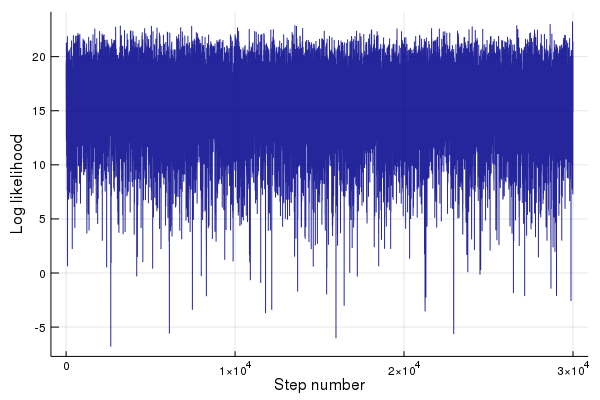

In [12]:
# Configure the stratigraphic Monte Carlo model
config = NewStratAgeModelConfiguration()
# If you in doubt, you can probably leave these parameters as-is
config.resolution = 1.0 # Same units as sample height. Smaller is slower!
config.bounding = 0.1 # how far away do we place runaway bounds, as a fraction of total section height
(bottom, top) = extrema(smpl.Height)
npoints_approx = round(Int,length(bottom:config.resolution:top) * (1 + 2*config.bounding))
config.nsteps = 30000 # Number of steps to run in distribution MCMC
config.burnin = 20000*npoints_approx # Number to discard
config.sieve = round(Int,npoints_approx) # Record one out of every nsieve steps

# Run the stratigraphic MCMC model
(mdl, agedist, lldist) = StratMetropolisDist(smpl, config); sleep(0.5)

# Plot the log likelihood to make sure we're converged (n.b burnin isn't recorded)
plot(lldist,xlabel="Step number",ylabel="Log likelihood",label="",line=(0.85,:darkblue))

***
## Plot results

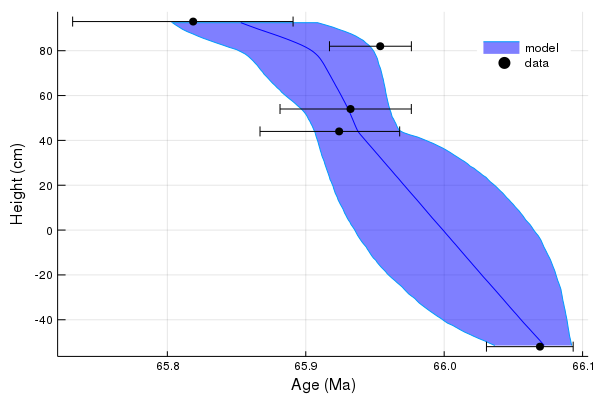

In [13]:
# Plot results (mean and 95% confidence interval for both model and data)
hdl = plot([mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(minimum(mdl.Height),0.5,:blue), label="model")
plot!(hdl, mdl.Age, mdl.Height, linecolor=:blue, label="", fg_color_legend=:white)
plot!(hdl, smpl.Age, smpl.Height, xerror=(smpl.Age-smpl.Age_025CI,smpl.Age_975CI-smpl.Age),label="data",seriestype=:scatter,color=:black)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Height ($(smpl.Height_Unit))")
savefig(hdl,"AgeDepthModel.pdf");
display(hdl)

Interpolated age: 65.99916133980349 +0.06558734346594974/-0.06378174678590653 Ma

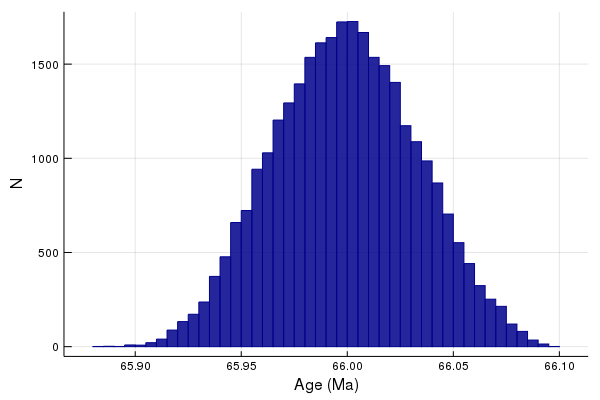

In [14]:
# Interpolate results at KTB (height = 0)
height = 0
KTB = linterp1s(mdl.Height,mdl.Age,height)
KTB_min = linterp1s(mdl.Height,mdl.Age_025CI,height)
KTB_max = linterp1s(mdl.Height,mdl.Age_975CI,height)
print("Interpolated age: $KTB +$(KTB_max-KTB)/-$(KTB-KTB_min) Ma")

# We can also interpolate the full distribution:
interpolated_distribution = Array{Float64}(undef,size(agedist,2))
for i=1:size(agedist,2)
    interpolated_distribution[i] = linterp1s(mdl.Height,agedist[:,i],height)
end
histogram(interpolated_distribution, xlabel="Age (Ma)", ylabel="N", label="", fill=(0.85,:darkblue), linecolor=:darkblue)

There are other things we can plot as well, such as deposition rate:

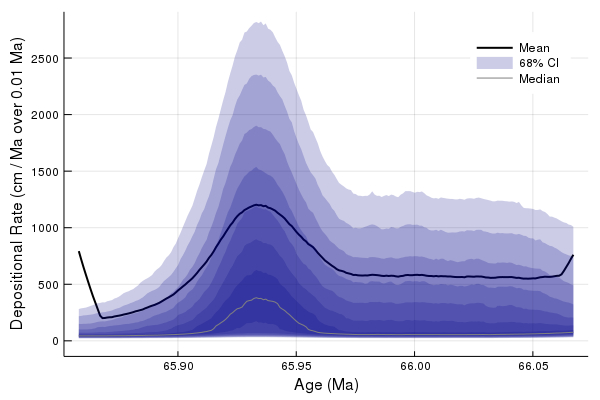

  0.803130 seconds (1.22 M allocations: 407.420 MiB, 22.77% gc time)


In [15]:
# Set bin width and spacing
binwidth = 0.01 # Myr
binoverlap = 10
ages = collect(minimum(mdl.Age):binwidth/binoverlap:maximum(mdl.Age))
bincenters = ages[1+Int(binoverlap/2):end-Int(binoverlap/2)]
spacing = binoverlap

# Calculate rates for the stratigraphy of each markov chain step
dhdt_dist = Array{Float64}(undef, length(ages)-binoverlap, config.nsteps)
@time for i=1:config.nsteps
    heights = linterp1(reverse(agedist[:,i]), reverse(mdl.Height), ages)
    dhdt_dist[:,i] = abs.(heights[1:end-spacing] - heights[spacing+1:end]) ./ binwidth
end

# Find mean and 1-sigma (68%) CI
dhdt = nanmean(dhdt_dist,dim=2)
dhdt_50p = nanmedian(dhdt_dist,dim=2)
dhdt_16p = pctile(dhdt_dist,15.865,dim=2) # Minus 1-sigma (15.865th percentile)
dhdt_84p = pctile(dhdt_dist,84.135,dim=2) # Plus 1-sigma (84.135th percentile)
# Other confidence intervals (10:10:50)
dhdt_20p = pctile(dhdt_dist,20,dim=2)
dhdt_80p = pctile(dhdt_dist,80,dim=2)
dhdt_25p = pctile(dhdt_dist,25,dim=2)
dhdt_75p = pctile(dhdt_dist,75,dim=2)
dhdt_30p = pctile(dhdt_dist,30,dim=2)
dhdt_70p = pctile(dhdt_dist,70,dim=2)
dhdt_35p = pctile(dhdt_dist,35,dim=2)
dhdt_65p = pctile(dhdt_dist,65,dim=2)
dhdt_40p = pctile(dhdt_dist,40,dim=2)
dhdt_60p = pctile(dhdt_dist,60,dim=2)
dhdt_45p = pctile(dhdt_dist,45,dim=2)
dhdt_55p = pctile(dhdt_dist,55,dim=2)

# Plot results
hdl = plot(bincenters,dhdt, label="Mean", color=:black, linewidth=2)
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_16p; reverse(dhdt_84p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="68% CI")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_20p; reverse(dhdt_80p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_25p; reverse(dhdt_75p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_30p; reverse(dhdt_70p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_35p; reverse(dhdt_65p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_40p; reverse(dhdt_60p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_45p; reverse(dhdt_55p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,bincenters,dhdt_50p, label="Median", color=:grey, linewidth=1)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Depositional Rate ($(smpl.Height_Unit) / $(smpl.Age_Unit) over $binwidth $(smpl.Age_Unit))", fg_color_legend=:white)
# savefig(hdl,"DepositionRateModelCI.pdf")
display(hdl)

***
## Stratigraphic model including hiatuses
We can also deal with discrete hiatuses in the stratigraphic section if we know where they are and about how long they lasted. We need some different models and methods though. In particular, in addition to the `StratAgeData` struct, we also need a `HiatusData` struct now, and we're going to want to pass these to `StratMetropolisDistHiatus` instead of `StratMetropolisDist` like before.

In [16]:
# # Data about hiatuses
# nHiatuses = 2 # The number of hiatuses you have data for
# hiatus = NewHiatusData(nHiatuses) # Struct to hold data
# hiatus.Height         = [20.0, 35.0 ]
# hiatus.Height_sigma   = [ 0.0,  0.0 ]
# hiatus.Duration       = [ 0.2,  0.43]
# hiatus.Duration_sigma = [ 0.05, 0.07]

# # Run the model. Note: we're using `StratMetropolisDistHiatus` now, instead of just `StratMetropolisDistHiatus`
# (mdl, agedist, hiatusdist, lldist) = StratMetropolisDistHiatus(smpl, hiatus, config); sleep(0.5)

# # Plot results (mean and 95% confidence interval for both model and data)
# hdl = plot([mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(minimum(mdl.Height),0.5,:blue), label="model")
# plot!(hdl, mdl.Age, mdl.Height, linecolor=:blue, label="", fg_color_legend=:white)
# plot!(hdl, smpl.Age, smpl.Height, xerror=(smpl.Age-smpl.Age_025CI,smpl.Age_975CI-smpl.Age),label="data",seriestype=:scatter,color=:black)
# plot!(hdl, xlabel="Age (Ma)", ylabel="Height (cm)")

***
[![DOI](https://github.com/brenhinkeller/Chron.jl/raw/master/readme_figures/osf_io_TQX3F.svg?sanitize=true)](https://doi.org/10.17605/osf.io/TQX3F) 